# <center> Process of cleaning and analyzing horse racing data from Kaggle dataset "Horses for Courses"</center>

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare, ttest_ind
import seaborn as sns

%matplotlib inline

#Supresses scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import warnings
warnings.filterwarnings('ignore')

In [2]:
#There are a lot of issues with the 'position_two' column, so I left it out.
#Furthermore, the 'position_again' column is much more consistent and has all relevant win/place information  

fields = ["position_again","bf_odds","venue_name","date","market_name","condition","barrier","handicap_weight","last_five_starts","prize_money","sex","age","jockey_sex","days_since_last_run","overall_starts","overall_wins","overall_places","track_starts","track_wins","track_places","firm_starts","firm_wins","firm_places","good_starts","good_wins","good_places","slow_starts","slow_wins","slow_places","soft_starts","soft_wins","soft_places","heavy_starts","heavy_wins","heavy_places","distance_starts","distance_wins","distance_places"]
# will use "jockey","trainer" later

df = pd.read_csv("horses.csv", skipinitialspace=True, usecols=fields, low_memory=False)

df.head()

,position_again,bf_odds,venue_name,date,market_name,condition,barrier,handicap_weight,last_five_starts,prize_money,...,slow_places,soft_starts,soft_wins,soft_places,heavy_starts,heavy_wins,heavy_places,distance_starts,distance_wins,distance_places
0,1.00,2.88,Echuca,2016-06-27,R3 1200m Mdn,HVY9,3.00,58.50,f3,2160.00,...,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00
1,2.00,15.00,Echuca,2016-06-27,R3 1200m Mdn,HVY9,10.00,58.50,x80x2,21175.00,...,1.00,2.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,1.00
2,3.00,95.00,Echuca,2016-06-27,R3 1200m Mdn,HVY9,6.00,56.50,79x00,28855.00,...,0.00,5.00,0.00,0.00,3.00,0.00,0.00,4.00,0.00,0.00
3,nan,20.00,Echuca,2016-06-27,R3 1200m Mdn,HVY9,2.00,56.50,f0,1475.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
4,nan,2.74,Echuca,2016-06-27,R3 1200m Mdn,HVY9,7.00,56.50,f4x,1215.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


In [3]:
df.date = pd.to_datetime(df.date, format='%Y'+'-'+'%m'+'-'+'%d')

#removes numbers from end of 'condition' strings
df.condition = df.condition.str.replace('\d+', '')

#renaming condition values so that they're uniform
df.condition = df.condition.replace(['HVY','AWT'], ['HEAVY','GOOD']) #AWT equates to a Good surface under some weather conditions

#reverses 'last_five_starts' (originally written right-to-left) so that it's easier to read in the future
df.last_five_starts = df.last_five_starts.str[::-1]

## Useful Functions:

In [4]:
def column_cleaner(cleaned_df, grouped_df, column_name):
    non_null_indices = grouped_df[column_name].apply(lambda x: all(x.notnull()))
    
    non_null_df = cleaned_df[non_null_indices]
    
    non_null_grouped = non_null_df.groupby(['date','venue_name','market_name'])
    
    clean_indices = non_null_grouped[column_name].value_counts(normalize=True,dropna=False).where(lambda x:x != 1).dropna().index.droplevel(column_name)
    
    new_cleaned_df = non_null_df.loc[clean_indices].drop_duplicates()
    return new_cleaned_df

def cleaned_win_df(cleaned_df):
    win_indices = cleaned_df.position_again.apply(lambda x:x == 1)
    
    df_cleaned_win = cleaned_df[win_indices]
    return df_cleaned_win

# Creating new features and dropping others:

## Creating general and track-condition-specific 'win_percent' and 'place_percent' columns:

In [5]:
#creates overall, track, and distance win_percent and place_percent columns and drops existing wins and places columns

columns_list = ["overall","track","distance"]

for x in columns_list:
    df[x+"_win_percent"] = df[x+"_wins"]/df[x+"_starts"]
    
    df[x+"_place_percent"] = df[x+"_places"]/df[x+"_starts"]

    # dropping various columns, though 'starts' columns will be used later
    df.drop([x+'_wins', x+'_places'], axis=1, inplace=True)

In [6]:
#creates a condition_starts ,condition_win_percent, and condition_place_percent column for each horse according to the condition of the track for that race

df.loc[df.condition.isna(), "condition_win_percent"] = np.nan

condition_list = ["firm","good","slow","soft","heavy"]

for x in condition_list: 
    df.loc[df.condition.str.lower() == x, "condition_starts"] = df[x+"_starts"]
    
    df.loc[df.condition.str.lower() == x, "condition_win_percent"] = df[x+"_wins"]/df[x+"_starts"]
    
    df.loc[df.condition.str.lower() == x, "condition_place_percent"] = df[x+"_places"]/df[x+"_starts"]
    
    df.drop([x+'_wins', x+'_places'], axis=1, inplace=True)

# Condition column is not necessary now that there are condition win and place percent columns 
df.drop('condition', axis=1, inplace=True)

# Replaces infinity (zero division) with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

## Splits last_five_starts column into 5 separate columns, replaces values, then drops last_five_starts:

In [7]:
new = pd.DataFrame()

for i in range(5):
    new[i] = df.last_five_starts.str[i:i+1]

for i in range(5):
    df['last_start'+str(i+1)] = new[i].replace(['','x','f',0],[np.nan,50,100,10])
    
df.drop('last_five_starts',axis=1,inplace=True)

## Cleaning data by removing races with missing win and/or place values in 'position_again' column:

In [8]:
#Used groupby to create indices by which to sort the re-indexed dataframes below, like df_indexed and df_cleaned
df_grouped = df.groupby(['date','venue_name','market_name'])

#Drops all groups/races in 'position_again' column where sum of values [1st, 2nd, 3rd] don't add to 3 or 6
#i.e. 1+2 and 1+2+3
index_list1 = df_grouped.position_again.sum(dropna=False).where(lambda x:(x == 3) | (x == 6)).dropna().index

df_indexed = df.set_index(['date','venue_name','market_name'])

df_cleaned = df_indexed.loc[index_list1].drop_duplicates()

df_grouped = df_cleaned.groupby(['date','venue_name','market_name'])

#Eliminates remaining errors in 'position_again' column by making sure that there isn't a single 3rd-place finish
index_list2 = df_grouped.position_again.value_counts(normalize=True,dropna=False).where(lambda x:x != 1).dropna().index.droplevel('position_again')
df_cleaned = df_cleaned.loc[index_list2].drop_duplicates()

df_grouped = df_cleaned.groupby(['date','venue_name','market_name'])

## Creating a weight_minus_average column:

In [9]:
average_weight = df_grouped.handicap_weight.transform('mean')

df_cleaned.insert(4,'average_weight',average_weight)

df_cleaned.insert(4,'weight_minus_average', df_cleaned.handicap_weight - df_cleaned.average_weight)

df_cleaned.drop('average_weight', axis=1, inplace=True)

df_grouped = df_cleaned.groupby(['date','venue_name','market_name'])

## Creating a prize_money_per_start_minus_average column:

### This may be one of the best indicators, as prize money is also an indicator of the difficulty of past races. Therefore, the value (meaningfulness) of past wins is taken into consideration.

In [10]:
#creates prize_money_per_start column
df_cleaned.insert(6,'prize_money_per_start', df_cleaned.prize_money/df_cleaned.overall_starts)

#Creates average_prize_money_per_start column
average_prize_money_per_start = df_grouped.prize_money_per_start.transform('mean')

df_cleaned.insert(7,'average_prize_money_per_start', average_prize_money_per_start)

#Creates prize_money_per_start_minus_average column
df_cleaned.insert(8,'prize_money_per_start_minus_average', df_cleaned.prize_money_per_start - df_cleaned.average_prize_money_per_start)

#drops irrelevant columns
df_cleaned.drop(['prize_money', 'prize_money_per_start', 'average_prize_money_per_start'], axis=1, inplace=True)

df_grouped = df_cleaned.groupby(['date','venue_name','market_name'])

### I was considering using a horse age_minus_average column, but I realized that age difference is not as good of an indicator as pure age. This is because the difference between a 2-year-old and a 4-year-old might mean little, but the difference between a 4 and 6-year-old might be a lot.

In [11]:
# Replaces infinity (zero division) with NaN
df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

df_grouped = df_cleaned.groupby(['date','venue_name','market_name'])

df_cleaned.head()

position_again  bf_odds  barrier  \
date       venue_name market_name                                        
2016-06-27 Echuca     R10 1400m Hcap            1.00    18.50    12.00   
                      R10 1400m Hcap            2.00    16.50     8.00   
                      R10 1400m Hcap            3.00    11.50     1.00   
                      R10 1400m Hcap             nan    19.00     5.00   
                      R10 1400m Hcap             nan     7.60     7.00   

                                      handicap_weight  weight_minus_average  \
date       venue_name market_name                                             
2016-06-27 Echuca     R10 1400m Hcap            57.50                 -0.62   
                      R10 1400m Hcap            59.00                  0.88   
                      R10 1400m Hcap            58.50                  0.38   
                      R10 1400m Hcap            58.50                  0.38   
                      R10 1400m Hcap            58.50                  0.38   

                                      prize_money_per_start_minus_average  \
date       venue_name market_name                                           
2016-06-27 Echuca     R10 1400m Hcap                             -1358.43   
                      R10 1400m Hcap                             -1238.46   
                      R10 1400m Hcap                             -1317.80   
                      R10 1400m Hcap                               878.84   
                      R10 1400m Hcap                               764.45   

                                          sex  age jockey_sex  \
date       venue_name market_name                               
2016-06-27 Echuca     R10 1400m Hcap     Mare 6.00       Male   
                      R10 1400m Hcap  Gelding 5.00       Male   
                      R10 1400m Hcap  Gelding 5.00       Male   
                      R10 1400m Hcap  Gelding 6.00       Male   
                      R10 1400m Hcap     Mare 4.00       Male   

                                      days_since_last_run  ...  \
date       venue_name market_name                          ...   
2016-06-27 Echuca     R10 1400m Hcap                16.00  ...   
                      R10 1400m Hcap                18.00  ...   
                      R10 1400m Hcap                13.00  ...   
                      R10 1400m Hcap                16.00  ...   
                      R10 1400m Hcap                13.00  ...   

                                      distance_win_percent  \
date       venue_name market_name                            
2016-06-27 Echuca     R10 1400m Hcap                  0.25   
                      R10 1400m Hcap                  0.22   
                      R10 1400m Hcap                  0.20   
                      R10 1400m Hcap                  0.19   
                      R10 1400m Hcap                  0.33   

                                      distance_place_percent  \
date       venue_name market_name                              
2016-06-27 Echuca     R10 1400m Hcap                    0.25   
                      R10 1400m Hcap                    0.22   
                      R10 1400m Hcap                    0.30   
                      R10 1400m Hcap                    0.19   
                      R10 1400m Hcap                    0.33   

                                      condition_win_percent  condition_starts  \
date       venue_name market_name                                               
2016-06-27 Echuca     R10 1400m Hcap                   0.00              4.00   
                      R10 1400m Hcap                   0.00              2.00   
                      R10 1400m Hcap                   1.00              1.00   
                      R10 1400m Hcap                   0.00              1.00   
                      R10 1400m Hcap                    nan              0.00   

                                      condition_place_

## Cleaned Dataframe Details:

In [12]:
df_cleaned.shape

(193000, 32)

In [13]:
len(df_grouped) #Number of races

19646

# Testing which features are significant:

## For horse gender:

In [14]:
#Removes races where only one horse gender is represented
sex_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'sex')

sex_pop_cleaned_win = cleaned_win_df(sex_pop_cleaned)

In [15]:
#General percentage of horse genders for races where multiple genders are represented  
sex_pop_cleaned.sex.value_counts(dropna=False,normalize=True).sort_values(ascending=False).drop('Unknown')

Gelding   0.57
Mare      0.27
Filly     0.13
Colt      0.03
Horse     0.01
Name: sex, dtype: float64

In [16]:
sex_pop_cleaned_win.sex.value_counts(dropna=False,normalize=True).sort_values(ascending=False).drop('Unknown')

Gelding   0.57
Mare      0.24
Filly     0.14
Colt      0.04
Horse     0.01
Name: sex, dtype: float64

In [17]:
horse_sex_pop = sex_pop_cleaned.sex.value_counts(dropna=False,normalize=True).sort_values(ascending=False).drop('Unknown')

horse_sex_win = sex_pop_cleaned_win.sex.value_counts(dropna=False,normalize=True).sort_values(ascending=False).drop('Unknown')

horse_sex_percent_difference = (horse_sex_win - horse_sex_pop)/horse_sex_pop

horse_sex_percent_difference

Gelding    0.00
Mare      -0.11
Filly      0.11
Colt       0.49
Horse      0.16
Name: sex, dtype: float64

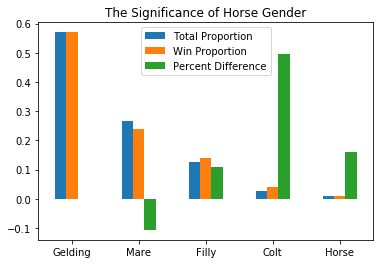

In [18]:
index1 = ['Gelding', 'Mare', 'Filly','Colt', 'Horse']

df1 = pd.DataFrame({'Total Proportion': horse_sex_pop,'Win Proportion': horse_sex_win , 'Percent Difference': horse_sex_percent_difference}, index=index1)

ax = df1.plot.bar(rot=0,title='The Significance of Horse Gender')

### Using the Pearson's chi-squared test for both ways of finding population, I find horse gender is significant:

In [19]:
observed1 = sex_pop_cleaned_win.sex.value_counts().sort_values(ascending=False).drop('Unknown').values
expected_percentages1 = horse_sex_pop.values
expected1 = [x*observed1.sum() for x in expected_percentages1]

test_stat1, p_value1 = chisquare(observed1, expected1)

test_stat1, p_value1

(200.61965028140648, 2.764700088846901e-42)

## For horse age:

In [20]:
#Removing races where there is only one age
age_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'age')

age_pop_cleaned_win = cleaned_win_df(age_pop_cleaned)

In [21]:
age_pop = age_pop_cleaned.age.value_counts(dropna=False,normalize=True).sort_index()

age_win = age_pop_cleaned_win.age.value_counts(dropna=False,normalize=True).sort_index()

age_percent_difference = (age_win - age_pop)/age_pop

In [22]:
age_percent_difference

2.00     0.12
3.00     0.24
4.00     0.12
5.00    -0.05
6.00    -0.18
7.00    -0.29
8.00    -0.32
9.00    -0.36
10.00   -0.56
11.00   -0.38
12.00   -0.74
Name: age, dtype: float64

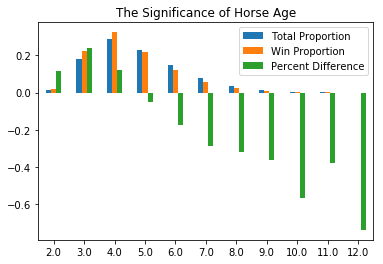

In [23]:
index2 = age_percent_difference.index

df2 = pd.DataFrame({'Total Proportion': age_pop,'Win Proportion': age_win , 'Percent Difference': age_percent_difference}, index=index2)

ax = df2.plot.bar(rot=0, title='The Significance of Horse Age')

### Using the Pearson's chi-squared test, I find horse age is significant:

In [24]:
observed2 = age_pop_cleaned_win.age.value_counts().sort_index().values
expected_percentages2 = age_pop.values
expected2 = [x*observed2.sum() for x in expected_percentages2]

test_stat2, p_value2 = chisquare(observed2, expected2)

test_stat2, p_value2

(599.9736827861257, 1.7839300688743352e-122)

## For handicap_weight:

In [25]:
#Removing races where there is only one age
weight_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'handicap_weight')

weight_pop_cleaned_win = cleaned_win_df(weight_pop_cleaned)

In [26]:
weight_pop_cleaned.handicap_weight.describe()

count   188688.00
mean        56.90
std          2.18
min          5.00
25%         55.00
50%         57.00
75%         58.50
max         74.00
Name: handicap_weight, dtype: float64

In [27]:
weight_pop_cleaned_win.handicap_weight.describe()

count   19093.00
mean       57.31
std         2.18
min        50.00
25%        56.00
50%        57.50
75%        58.50
max        74.00
Name: handicap_weight, dtype: float64

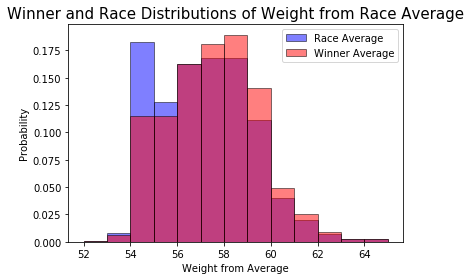

In [28]:
data7a = weight_pop_cleaned.handicap_weight.dropna().values

data7b = weight_pop_cleaned_win.handicap_weight.dropna().values

plt.title("Winner and Race Distributions of Weight from Race Average", fontsize=15)
plt.hist(data7a, density=True, bins=13, range=(52,65), label='Race Average', color='b', alpha=.5, edgecolor='k')
plt.hist(data7b, density=True, bins=13, range=(52,65), label='Winner Average', color='r', alpha=.5, edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('Weight from Average')
plt.ylabel('Probability');

### Using a 2-sample T-test, again I find that handicap_weight is significant:

In [29]:
test_stat7, p_value7 = ttest_ind(data7a, data7b)

test_stat7, p_value7

(-25.06287159141825, 2.0329986953277873e-138)

## For handicap_weight, using handicap weight_minus_average:

In [30]:
#I use the handicap_weight filters since the same races will be eliminated
weight_pop_cleaned.weight_minus_average.describe()

count   188688.00
mean         0.00
std          1.70
min        -48.67
25%         -1.17
50%         -0.09
75%          1.05
max         10.07
Name: weight_minus_average, dtype: float64

In [31]:
#average weight difference for winners
weight_pop_cleaned_win.weight_minus_average.describe()

count   19093.00
mean        0.40
std         1.70
min        -6.56
25%        -0.83
50%         0.38
75%         1.42
max         8.86
Name: weight_minus_average, dtype: float64

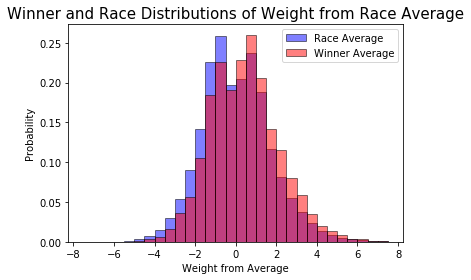

In [32]:
data2a = weight_pop_cleaned.weight_minus_average.dropna().values

data2b = weight_pop_cleaned_win.weight_minus_average.dropna().values

plt.title("Winner and Race Distributions of Weight from Race Average", fontsize=15)
plt.hist(data2a, density=True, bins=30, range=(-7.5,7.5), label='Race Average', color='b', alpha=.5, edgecolor='k')
plt.hist(data2b, density=True, bins=30, range=(-7.5,7.5), label='Winner Average', color='r', alpha=.5, edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('Weight from Average')
plt.ylabel('Probability');

### Using a 2-sample T-test, I find that handicap weight_minus_average is significant:

In [33]:
test_stat2, p_value2 = ttest_ind(data2a, data2b)

test_stat2, p_value2

(-31.297090729663307, 1.6194078891181326e-214)

## For prize money, using prize_money_per_start_minus_average:

In [34]:
money_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'prize_money_per_start_minus_average')

money_pop_cleaned_win = cleaned_win_df(weight_pop_cleaned)

In [35]:
money_pop_cleaned.prize_money_per_start_minus_average.describe()

count    151400.00
mean         -0.00
std        7619.62
min     -135088.49
25%       -1280.18
50%        -327.10
75%         651.70
max      663484.79
Name: prize_money_per_start_minus_average, dtype: float64

In [36]:
#Winner prize money 
money_pop_cleaned_win.prize_money_per_start_minus_average.describe()

count    17315.00
mean      2313.51
std      12064.23
min     -81745.15
25%       -291.30
50%        577.80
75%       2198.75
max     663484.79
Name: prize_money_per_start_minus_average, dtype: float64

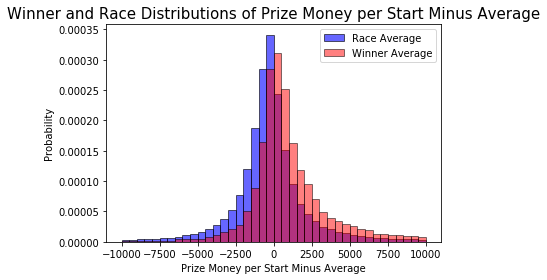

In [37]:
data3a = money_pop_cleaned.prize_money_per_start_minus_average.dropna().values
data3b = money_pop_cleaned_win.prize_money_per_start_minus_average.dropna().values

plt.title("Winner and Race Distributions of Prize Money per Start Minus Average", fontsize=15)
plt.hist(data3a, density=True, bins=40, range=(-10000,10000), label='Race Average', color='b', alpha=.6, edgecolor='k')
plt.hist(data3b, density=True, bins=40, range=(-10000,10000), label='Winner Average', color='r', alpha=.5, edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('Prize Money per Start Minus Average')
plt.ylabel('Probability');

### Using a 2-sample T-test, I find that prize money per start is significant:


In [38]:
test_stat3, p_value3 = ttest_ind(data3a, data3b)

test_stat3, p_value3

(-35.22190720040496, 8.971326566288987e-271)

## For overall wins:

In [39]:
overall_win_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'overall_win_percent')

overall_win_pop_cleaned_win = cleaned_win_df(overall_win_pop_cleaned)

In [40]:
overall_pop = overall_win_pop_cleaned.overall_win_percent.value_counts(normalize=True,bins=10).sort_index()

overall_win = overall_win_pop_cleaned_win.overall_win_percent.value_counts(normalize=True,bins=10).sort_index()

overall_percent_difference = (overall_win - overall_pop)/overall_pop

In [41]:
overall_percent_difference

(-0.002, 0.1]   -0.28
(0.1, 0.2]      -0.01
(0.2, 0.3]       0.17
(0.3, 0.4]       0.43
(0.4, 0.5]       0.69
(0.5, 0.6]       0.97
(0.6, 0.7]       1.18
(0.7, 0.8]       1.60
(0.8, 0.9]       2.28
(0.9, 1.0]       1.03
Name: overall_win_percent, dtype: float64

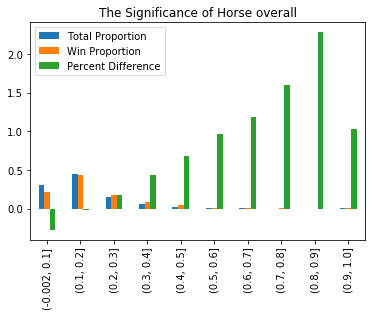

In [42]:
index3 = overall_percent_difference.index

df3 = pd.DataFrame({'Total Proportion': overall_pop,'Win Proportion': overall_win , 'Percent Difference': overall_percent_difference}, index=index3)

ax = df3.plot.bar(title='The Significance of Horse overall')

### There is high variance in the 100% column (aka beginner's luck). How many races before the 100% column is properly represented? That is, how many races is considered statistically significant?

### 90-100% column should be roughly 3.90 or 390%

In [43]:
overall_win_pop_grouped = overall_win_pop_cleaned.groupby(['date','venue_name','market_name'])

overall_starts_indices = overall_win_pop_grouped.overall_starts.agg('min').where(lambda x:x >= 5).dropna().index

overall_starts_cleaned = overall_win_pop_cleaned.loc[overall_starts_indices].drop_duplicates()

overall_starts_cleaned_win = cleaned_win_df(overall_starts_cleaned)

In [44]:
overall_starts_pop = overall_starts_cleaned.overall_win_percent.value_counts(normalize=True,bins=10).sort_index()

overall_starts_win = overall_starts_cleaned_win.overall_win_percent.value_counts(normalize=True,bins=10).sort_index()

overall_starts_percent_difference = (overall_starts_win - overall_starts_pop)/overall_starts_pop

In [45]:
overall_starts_percent_difference

(-0.002, 0.1]   -0.26
(0.1, 0.2]       0.00
(0.2, 0.3]       0.20
(0.3, 0.4]       0.44
(0.4, 0.5]       0.80
(0.5, 0.6]       1.19
(0.6, 0.7]       2.14
(0.7, 0.8]       1.47
(0.8, 0.9]       2.24
(0.9, 1.0]       6.29
Name: overall_win_percent, dtype: float64

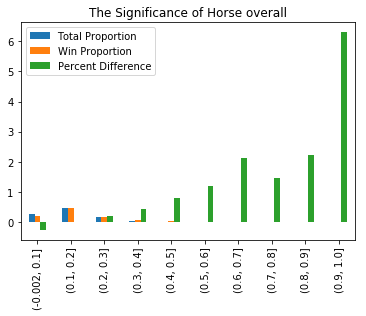

In [46]:
index4 = overall_starts_percent_difference.index

df4 = pd.DataFrame({'Total Proportion': overall_starts_pop,'Win Proportion': overall_starts_win , 'Percent Difference': overall_starts_percent_difference}, index=index4)

ax = df4.plot.bar(title='The Significance of Horse overall')

### It seems that a minimum of 5 races for all horses in the race gives the curve an exponential appearance.

## For Barrier:

In [47]:
barrier_pop_cleaned = column_cleaner(df_cleaned, df_grouped, 'barrier')

barrier_grouped = barrier_pop_cleaned.groupby(['date','venue_name','market_name'])

barrier_indices = barrier_grouped.barrier.value_counts().where(lambda x:x == 1).dropna().index.droplevel('barrier')

barrier_pop_cleaned = barrier_pop_cleaned.loc[barrier_indices]

barrier_pop_cleaned_win = cleaned_win_df(barrier_pop_cleaned)

In [48]:
barrier_pop = barrier_pop_cleaned.barrier.value_counts(normalize=True).sort_index().drop([18.00,19.00,20.00])

barrier_win = barrier_pop_cleaned_win.barrier.value_counts(normalize=True).sort_index().drop(18.00)

barrier_percent_difference = (barrier_win - barrier_pop)/barrier_pop

In [49]:
barrier_percent_difference

1.00     0.22
2.00     0.03
3.00     0.05
4.00     0.09
5.00     0.12
6.00     0.12
7.00    -0.02
8.00    -0.10
9.00    -0.11
10.00   -0.16
11.00   -0.20
12.00   -0.19
13.00   -0.35
14.00   -0.36
15.00   -0.13
16.00   -0.39
17.00   -0.15
Name: barrier, dtype: float64

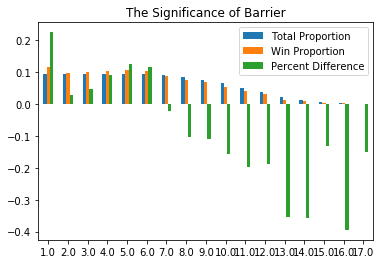

In [50]:
index5 = barrier_percent_difference.index

df5 = pd.DataFrame({'Total Proportion': barrier_pop,'Win Proportion': barrier_win , 'Percent Difference': barrier_percent_difference}, index=index5)

ax = df5.plot.bar(rot=0, title='The Significance of Barrier')

### Why is barrier 1 so overrepresented? Is there a problem with the data? There doesn't appear to be.

### Using the Pearson's chi-squared test, I find that barrier is significant:

In [51]:
observed3 = barrier_pop_cleaned_win.barrier.value_counts().sort_index().drop(18.00).values
expected_percentages3 = barrier_pop.values
expected3 = [x*observed3.sum() for x in expected_percentages3]

test_stat3, p_value3 = chisquare(observed3, expected3)

test_stat3, p_value3

(3787.9967204394943, 0.0)

## For jockey gender: 

#### Overall percentage of men and women in races where both are represented:

In [52]:
#Drops races where there is only one jockey gender, meaning that the other gender can't win
jockey_sex_cleaned = column_cleaner(df_cleaned, df_grouped, 'jockey_sex')

jockey_sex_cleaned_win = cleaned_win_df(jockey_sex_cleaned)

#### Finding the total a different way:

In [53]:
jockey_sex_cleaned.jockey_sex.value_counts(normalize=True)
#This amount is the sum of all 'male' and 'female' jockeys added together and THEN 'normalized'

Male     0.75
Female   0.25
Name: jockey_sex, dtype: float64

#### Win percentage of those races:

In [54]:
#Isolates wins in races with both jockey genders represented
jockey_sex_cleaned_win.jockey_sex.value_counts(normalize=True, dropna=False)

Male     0.79
Female   0.21
Name: jockey_sex, dtype: float64

In [55]:
#Finding the percent difference between win and total
jockey_sex_pop = jockey_sex_cleaned.jockey_sex.value_counts(normalize=True, dropna=False).values

jockey_sex_win = jockey_sex_cleaned_win.jockey_sex.value_counts(normalize=True, dropna=False).values

jockey_sex_percent_difference = (jockey_sex_win - jockey_sex_pop)/jockey_sex_pop

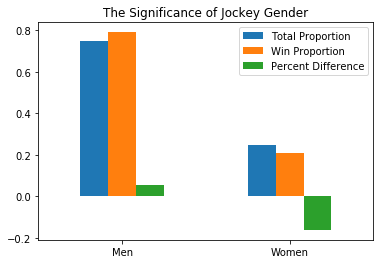

In [56]:
index6 = ['Men','Women']

df6 = pd.DataFrame({'Total Proportion': jockey_sex_pop,'Win Proportion': jockey_sex_win , 'Percent Difference': jockey_sex_percent_difference}, index=index6)

ax = df6.plot.bar(rot=0, title='The Significance of Jockey Gender')

### Using a 2-proportion z-test, I find that jockey gender is significant with a p-value of 2.3E-30
#### (There is currently a bug with the statsmodels library concering compatibility with scipy, so I used a scientific calculator)

# How often would you win and what would be your expected return if you always bet on the favorite?

In [57]:
odds_cleaned = column_cleaner(df_cleaned, df_grouped, 'bf_odds')

In [58]:
#creates dataframe with a unique index
odds_cleaned['uniq_idx'] = range(len(odds_cleaned))
odds_cleaned_uniq_idx = odds_cleaned.set_index('uniq_idx',append=True)
uniq_idx_grouped = odds_cleaned_uniq_idx.groupby(['date','venue_name','market_name'])

odds_cleaned_uniq_idx.head()

position_again  bf_odds  \
date       venue_name market_name    uniq_idx                            
2016-06-27 Echuca     R10 1400m Hcap 0                   1.00    18.50   
                                     1                   2.00    16.50   
                                     2                   3.00    11.50   
                                     3                    nan    19.00   
                                     4                    nan     7.60   

                                               barrier  handicap_weight  \
date       venue_name market_name    uniq_idx                             
2016-06-27 Echuca     R10 1400m Hcap 0           12.00            57.50   
                                     1            8.00            59.00   
                                     2            1.00            58.50   
                                     3            5.00            58.50   
                                     4            7.00            58.50   

                                               weight_minus_average  \
date       venue_name market_name    uniq_idx                         
2016-06-27 Echuca     R10 1400m Hcap 0                        -0.62   
                                     1                         0.88   
                                     2                         0.38   
                                     3                         0.38   
                                     4                         0.38   

                                               prize_money_per_start_minus_average  \
date       venue_name market_name    uniq_idx                                        
2016-06-27 Echuca     R10 1400m Hcap 0                                    -1358.43   
                                     1                                    -1238.46   
                                     2                                    -1317.80   
                                     3                                      878.84   
                                     4                                      764.45   

                                                   sex  age jockey_sex  \
date       venue_name market_name    uniq_idx                            
2016-06-27 Echuca     R10 1400m Hcap 0            Mare 6.00       Male   
                                     1         Gelding 5.00       Male   
                                     2         Gelding 5.00       Male   
                                     3         Gelding 6.00       Male   
                                     4            Mare 4.00       Male   

                                               days_since_last_run  ...  \
date       venue_name market_name    uniq_idx                       ...   
2016-06-27 Echuca     R10 1400m Hcap 0                       16.00  ...   
                                     1                       18.00  ...   
                                     2                       13.00  ...   
                                     3                       16.00  ...   
                                     4                       13.00  ...   

                                               distance_win_percent  \
date       venue_name market_name    uniq_idx                         
2016-06-27 Echuca     R10 1400m Hcap 0                         0.25   
                                     1                         0.22   
                                     2                         0.20   
                                     3                         0.19   
                                     4                         0.33   

                                               distance_place_percent  \
date       venue_name market_name    uniq_idx                           
2016-06-27 Echuca     R10 1400m Hcap 0                           0.25   
                                     1                           0.22   
                                     2                           0

In [59]:
average = uniq_idx_grouped.bf_odds.agg('min').mean()

In [60]:
bf_min_indices = uniq_idx_grouped.bf_odds.idxmin
    
min_odds_cleaned = odds_cleaned_uniq_idx.loc[bf_min_indices].drop_duplicates()

min_odds_win = cleaned_win_df(min_odds_cleaned)

odds_pop = len(min_odds_cleaned)
odds_win = len(min_odds_win)

print(len(min_odds_cleaned))
print(len(min_odds_win))

19646
6768


### How often the favorite wins:

In [61]:
odds_win/odds_pop

0.3444976076555024

### The expected return if betting 1 dollar on favorite every race:

In [62]:
-1*(1-odds_win/odds_pop) + average*odds_win/odds_pop

0.48483747011091194

# Beginning the Machine Learning Process:

In [63]:
import xgboost as xgb

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

In [64]:
df_cleaned_test = df_cleaned

df_cleaned_test.sex = df_cleaned_test.sex.replace(['Gelding', 'Mare', 'Filly', 'Colt', 'Horse', 'Unknown'], [0, 1, 2, 3, 4, np.nan])

df_cleaned_test.jockey_sex = df_cleaned_test.jockey_sex.replace(['Male','Female'], [0, 1])

df_cleaned_test.position_again = df_cleaned_test.position_again.replace([2,3,np.nan], [0,0,0])

df_cleaned_test = df_cleaned_test.convert_objects(convert_numeric=True)

## Randomizing dataframe by groups:

In [65]:
import random

groups = [df_cleaned_test for _, df_cleaned_test in df_cleaned_test.groupby(['date','venue_name','market_name'])]

random.shuffle(groups)

df_random_grouped = pd.concat(groups)

df_random_grouped['uniq_idx'] = range(len(df_random_grouped))
odds_cleaned_uniq_idx = df_random_grouped.set_index('uniq_idx',append=True)

In [66]:
# Separate into feature set and target variable
X_all = df_random_grouped.drop('position_again',axis=1)
y_all = df_random_grouped['position_again']

In [67]:
df_random_grouped

position_again  bf_odds  barrier  \
date       venue_name  market_name                                       
2018-01-07 Albany      R2 1500m Mdn             1.00     2.68     9.00   
                       R2 1500m Mdn             0.00     9.00     4.00   
                       R2 1500m Mdn             0.00    16.00     5.00   
                       R2 1500m Mdn             0.00     2.82     3.00   
                       R2 1500m Mdn             0.00    60.00     7.00   
                       R2 1500m Mdn             0.00    15.00     6.00   
                       R2 1500m Mdn             0.00    95.00    10.00   
                       R2 1500m Mdn             0.00    55.00     8.00   
                       R2 1500m Mdn             0.00   120.00     1.00   
2018-06-17 Devonport   R1 1150m Mdn             1.00     4.80     2.00   
                       R1 1150m Mdn             0.00    30.00     4.00   
                       R1 1150m Mdn             0.00    15.50     6.00   
                       R1 1150m Mdn             0.00    11.50    13.00   
                       R1 1150m Mdn             0.00     4.30     8.00   
                       R1 1150m Mdn             0.00     6.20     9.00   
                       R1 1150m Mdn             0.00    90.00    14.00   
                       R1 1150m Mdn             0.00    18.50     3.00   
                       R1 1150m Mdn             0.00    29.00    10.00   
                       R1 1150m Mdn             0.00    60.00    12.00   
                       R1 1150m Mdn             0.00    70.00    11.00   
                       R1 1150m Mdn             0.00   110.00     1.00   
                       R1 1150m Mdn             0.00    11.00     5.00   
                       R1 1150m Mdn             0.00    80.00     7.00   
2018-03-08 Pakenham    R4 1200m Mdn             1.00    36.00     3.00   
                       R4 1200m Mdn             0.00     1.48     8.00   
                       R4 1200m Mdn             0.00    21.00     2.00   
                       R4 1200m Mdn             0.00    21.00     1.00   
                       R4 1200m Mdn             0.00     6.20     9.00   
                       R4 1200m Mdn             0.00    27.00     4.00   
                       R4 1200m Mdn             0.00   450.00     5.00   
...                                              ...      ...      ...   
2017-07-06 Rockhampton R5 1200m 3yo             0.00     4.50     4.00   
                       R5 1200m 3yo             0.00    23.00     3.00   
                       R5 1200m 3yo             0.00    16.00    11.00   
                       R5 1200m 3yo             0.00    20.00     2.00   
                       R5 1200m 3yo             0.00    32.00     9.00   
                       R5 1200m 3yo             0.00    30.00    10.00   
2017-04-10 Bendigo     R1 3200m Stpl            1.00     2.14      nan   
                       R1 3200m Stpl            0.00     4.10      nan   
2018-06-30 Gundagai    R6 1400m Hcap            1.00    15.00    11.00   
                       R6 1400m Hcap            0.00    30.00    12.00   
                       R6 1400m Hcap            0.00    18.00     1.00   
                       R6 1400m Hcap            0.00     6.60     8.00   
                       R6 1400m Hcap            0.00     4.90     6.00   
                       R6 1400m Hcap            0.00    26.00     4.00   
                       R6 1400m Hcap            0.00     4.60     9.00   
                       R6 1400m Hcap            0.00     5.80    10.00   
                       R6 1400m Hcap            0.00    17.50     3.00   
                       R6 1400m Hcap            0.00    65.00     5.00   
                       R6 1400m Hcap            0.00   130.00     7.00   
2018-03-24 Ascot       R3 1400m Hcap            1.00    10.50     6.00   
                       R3 1400m Hcap            0.00    18.50     8.00   
                       R3 1400m Hcap      

In [ ]:
X_train, X_test, y_train, y_test = X_all.loc[15717:, :], X_all.loc[:15717, :], y_all.loc[15717:, :], y_all.loc[:15717, :]